In [1]:
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs
import matplotlib.pyplot as plt 

warnings.filterwarnings("ignore")

# Data 

In [2]:
# Futures tickers from yahoo finance
cl_f = "CL=F"
rb_f = "RB=F"
ho_f = "HO=F"

# Refiner symbol
refiner = "PSX"

In [3]:
# Set the start and the end dates
start = "2021-01-01"
end = "2023-12-31"

In [4]:
# Set the rolling window for Z-score
window = 22

In [5]:
# Download the history
data = yf.download([cl_f, rb_f, ho_f, refiner], start=start, end=end)["Adj Close"]

[*********************100%***********************]  4 of 4 completed


# Create a crack spread

In [6]:
# Construct the crack spread which is defined as long 3 crude oil contracts, 2 short gasoline contracts
# and 1 short heating oil contract

data["crack"] = (3 * data[cl_f] - 2 * data[rb_f] - data[ho_f])

In [7]:
# Create a series with the spread between the crack spread and refiner's price
data["spread"] = (data.crack - data[refiner])

In [8]:
# Compute the returns of each position
data["returns"] = data.spread.apply(np.log).diff(1)

In [9]:
# Compute the rolling Z score of spread between the crack spread and the refiner's price
data["z"] = (data.spread - data.spread.rolling(window).mean())/data.spread.rolling(window).std()

In [10]:
# Create a position indicator to get short the spread if it increases above 2 standard deviations
data["position"] = np.select([data.z < -1.95, data.z > 1.95], [1, -1], default = 0)

In [11]:
# How many trades (exits/entries) would be executed
len(data[data["position"] != -0])

65

In [12]:
# How many long positions
len(data[data["position"] == 1])

34

In [13]:
len(data[data["position"] == -1])

31

In [14]:
# Compute the returns of the strategy
strategy_returns = pd.DataFrame(data.position.shift(1) * data.returns)
strategy_returns.columns = ["strategy_returns"]

In [15]:
strategy_returns['Cum_Return'] = (1 + strategy_returns['strategy_returns']).cumprod() - 1

In [46]:
data

Ticker,CL=F,HO=F,PSX,RB=F,crack,spread,returns,z,position,upper,lower
Date,,,,,,,,,,,
2021-01-04,47.619999,1.4620,59.636971,1.3729,138.652197,79.015226,NaN,NaN,0,1.95,-1.95
2021-01-05,49.930000,1.5189,61.232861,1.4521,145.366901,84.134040,0.062771,NaN,0,1.95,-1.95
2021-01-06,50.630001,1.5287,60.780560,1.4750,147.411303,86.630744,0.029244,NaN,0,1.95,-1.95
2021-01-07,50.830002,1.5381,61.326729,1.4827,147.986506,86.659777,0.000335,NaN,0,1.95,-1.95
2021-01-08,52.240002,1.5795,60.345303,1.5423,152.055905,91.710603,0.056648,NaN,0,1.95,-1.95
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,73.559998,2.6612,129.808594,2.1301,213.758593,83.949999,-0.008007,NaN,0,1.95,-1.95
2023-12-26,75.570000,2.6688,131.415970,2.1583,219.724599,88.308629,0.050616,-0.007550,0,1.95,-1.95
2023-12-27,74.110001,2.6239,130.428299,2.1550,215.396102,84.967803,-0.038565,-0.295575,0,1.95,-1.95


# Analyze

<Axes: title={'center': 'Strategy Cumulative Return'}, xlabel='Date'>

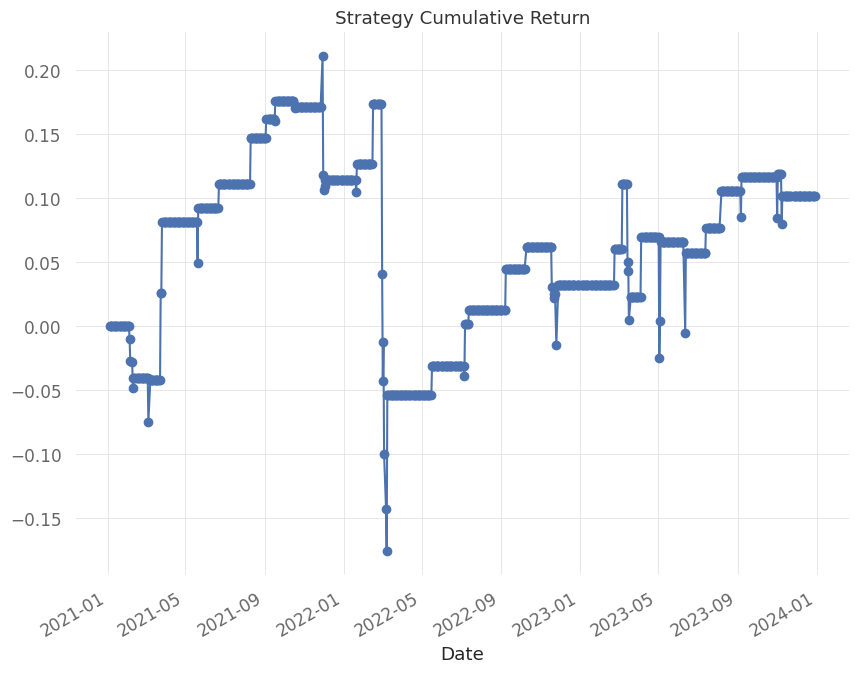

In [18]:
strategy_returns['Cum_Return'].plot(title='Strategy Cumulative Return',
                                    grid=True, 
                                    style="-o", 
                                    figsize=(10, 8), 
                                   )

<Axes: title={'center': 'Exits and Entries analysis'}, xlabel='Date', ylabel='Z-score'>

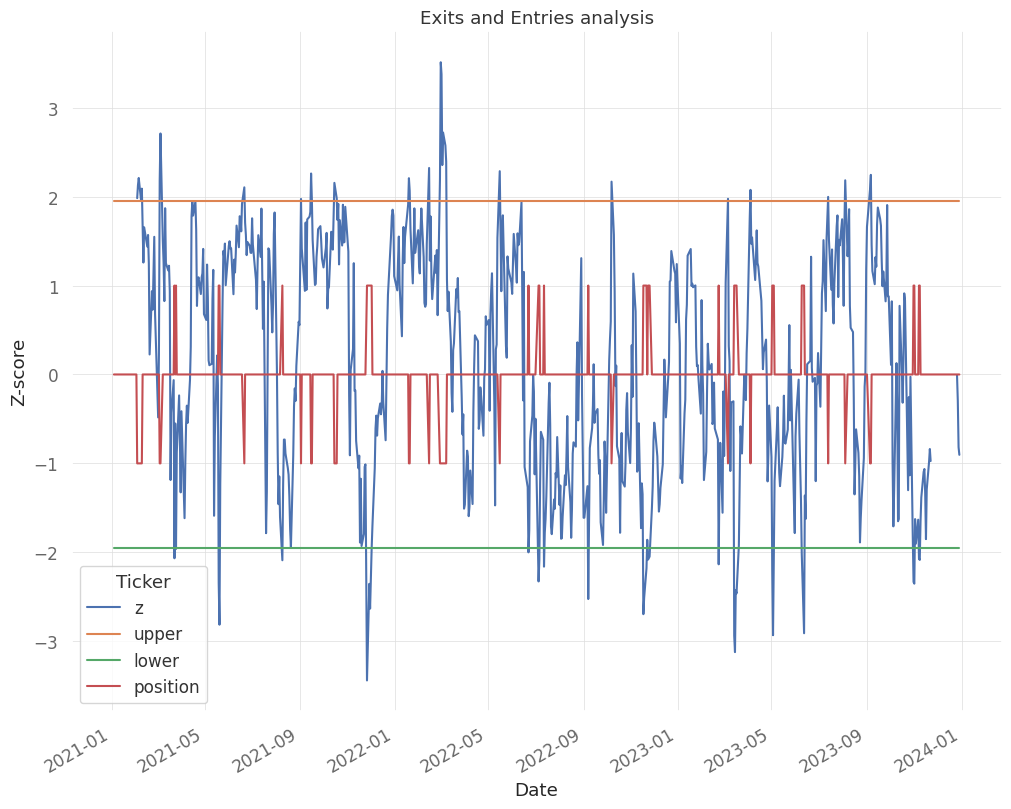

In [36]:
data["upper"] = 1.95
data["lower"] = -1.95
data[["z", "upper","lower", "position"]].plot(title='Exits and Entries analysis',
                                  ylabel = 'Z-score', 
                                    grid=True, 
                                    figsize=(12,10))

In [20]:
qs.reports.metrics(strategy_returns["strategy_returns"])

                    Strategy
------------------  ----------
Start Period        2021-01-05
End Period          2023-12-29
Risk-Free Rate      0.0%
Time in Market      9.0%

Cumulative Return   10.15%
CAGR﹪              2.26%

Sharpe              0.26
Prob. Sharpe Ratio  67.37%
Sortino             0.37
Sortino/√2          0.26
Omega               1.16

Max Drawdown        -31.88%
Longest DD Days     760

Gain/Pain Ratio     0.16
Gain/Pain (1M)      0.45

Payoff Ratio        0.82
Profit Factor       1.16
Common Sense Ratio  -
CPC Index           0.56
Tail Ratio          -
Outlier Win Ratio   27.26
Outlier Loss Ratio  1.2

MTD                 0.0%
3M                  -1.33%
6M                  4.22%
YTD                 6.77%
1Y                  6.77%
3Y (ann.)           2.32%
5Y (ann.)           2.26%
10Y (ann.)          2.26%
All-time (ann.)     2.26%

Avg. Drawdown       -8.6%
Avg. Drawdown Days  170
Recovery Factor     0.5
Ulcer Index         0.12
Serenity Index      0.08


In [34]:
# Conditional Value at Risk
qs.stats.cvar(strategy_returns["strategy_returns"])

-0.054163462023040024

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


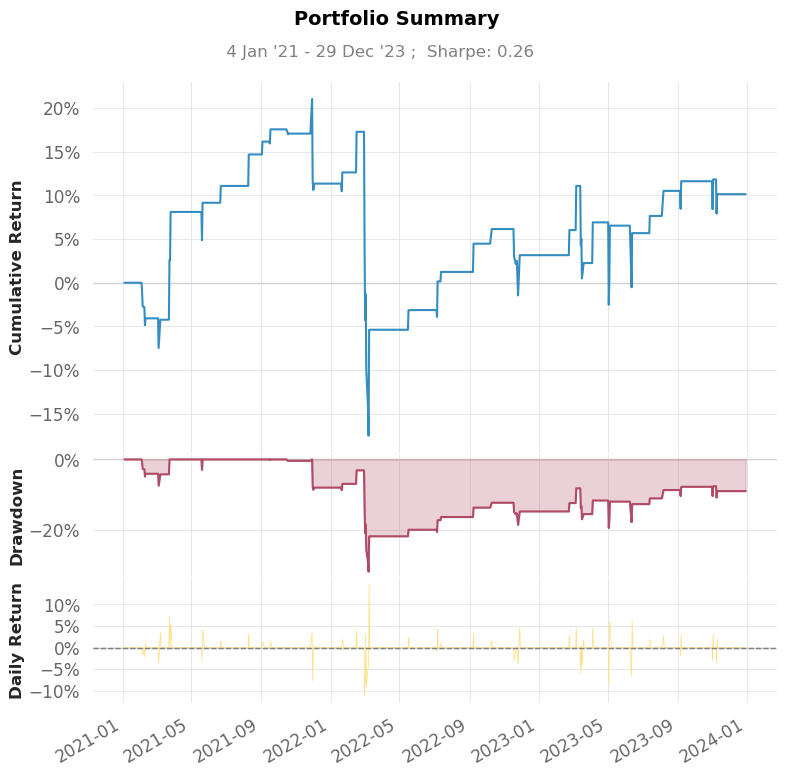

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


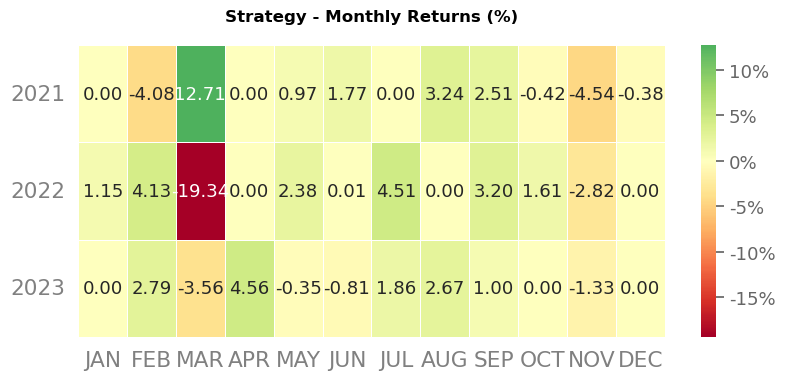

In [38]:
qs.reports.plots(strategy_returns["strategy_returns"])

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


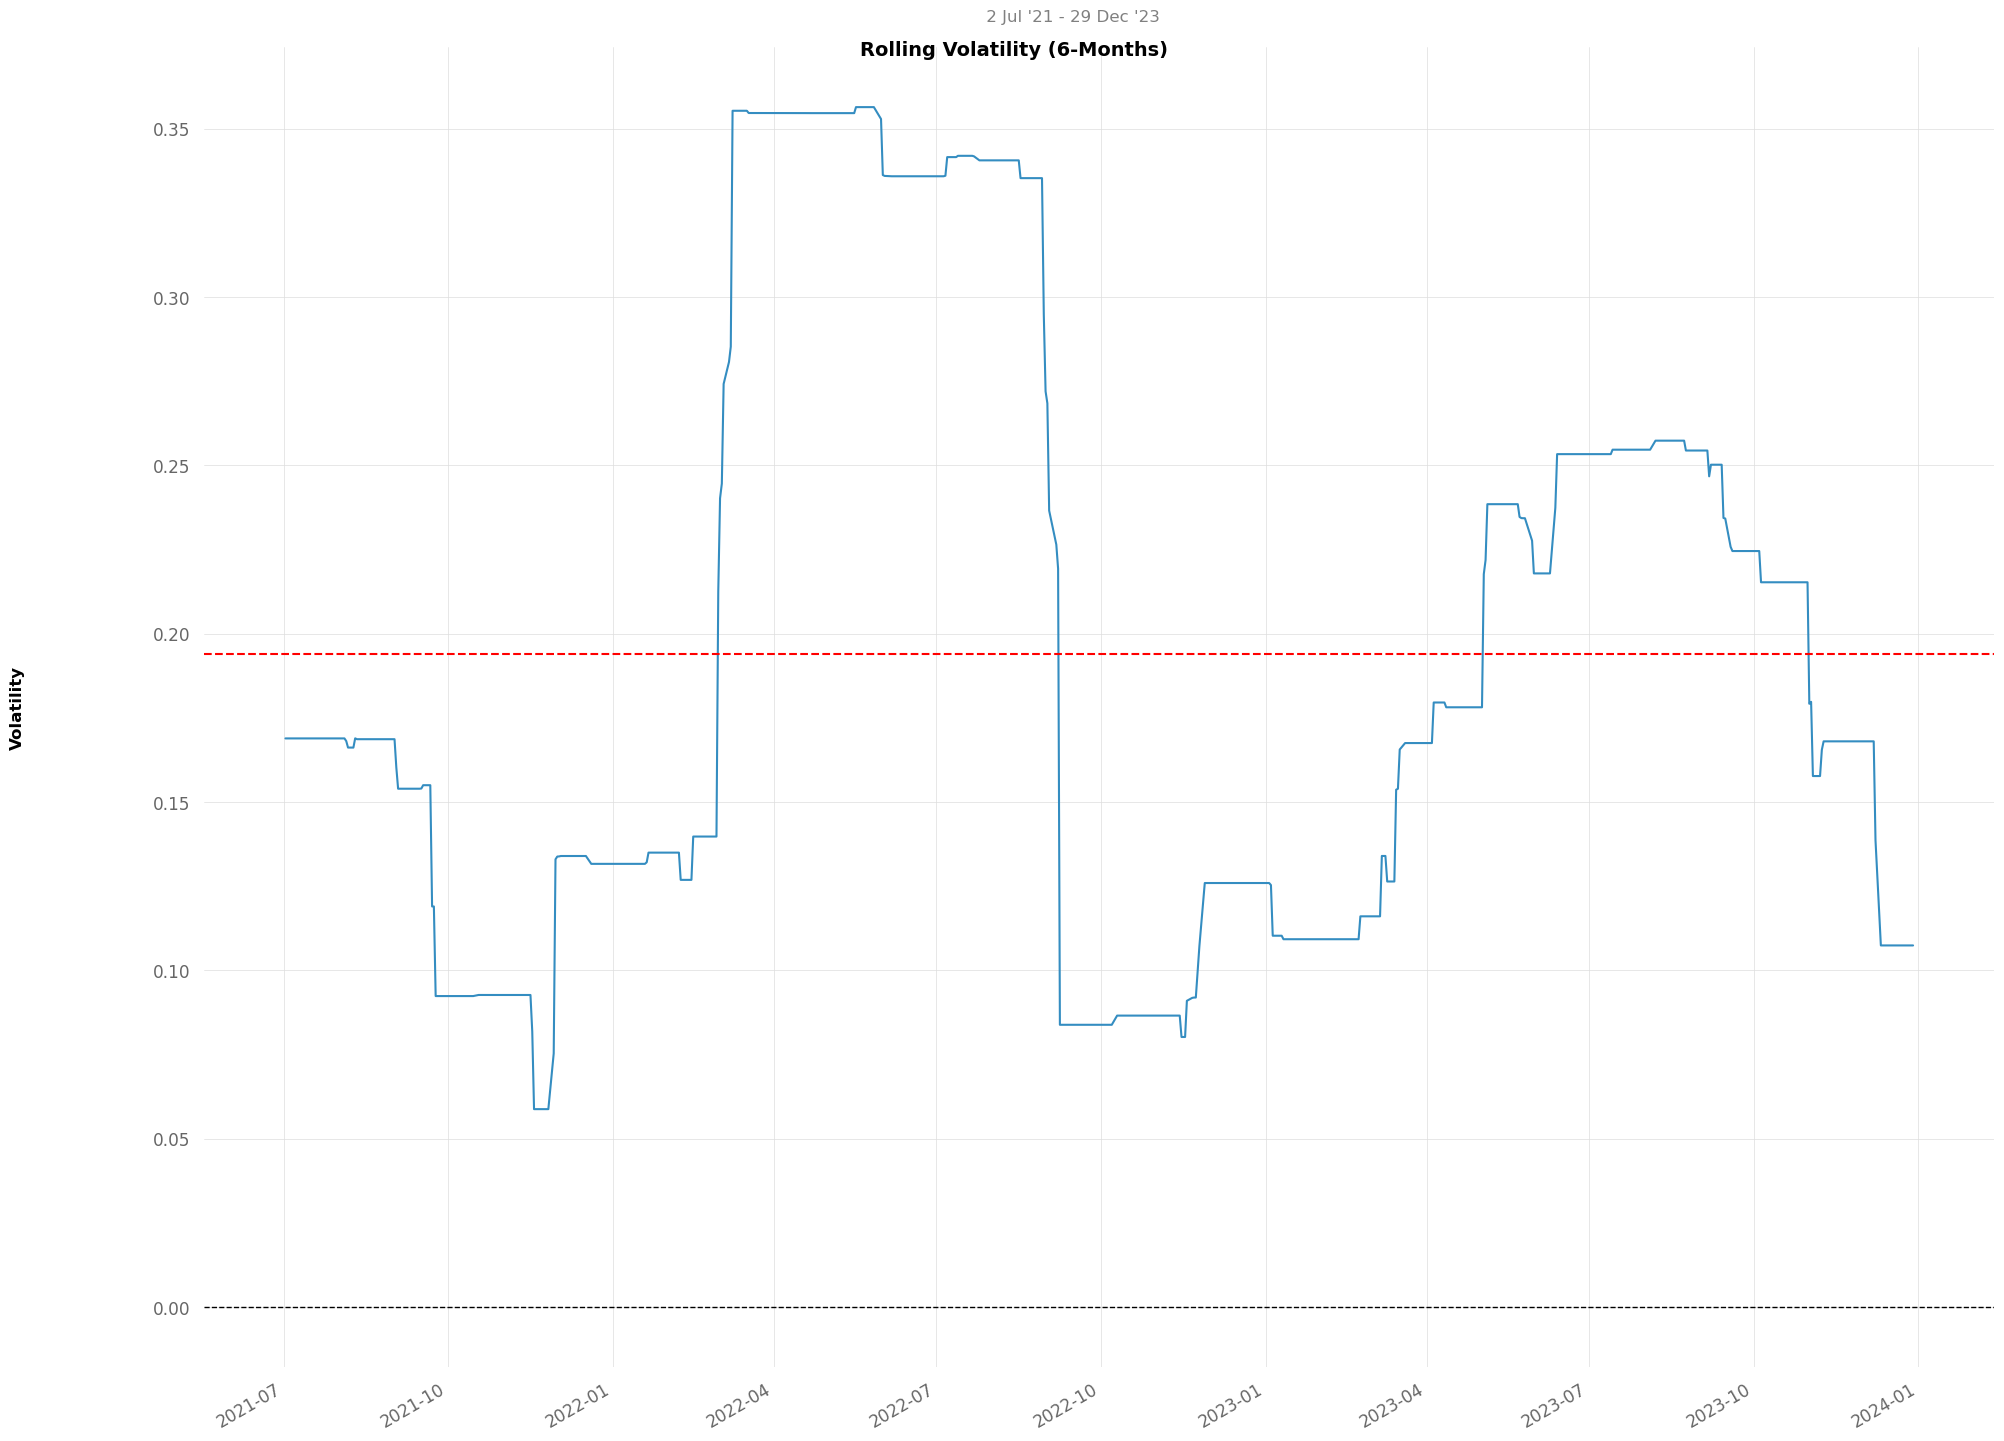

In [45]:
qs.plots.rolling_volatility(strategy_returns["strategy_returns"],figsize=(20,15))

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


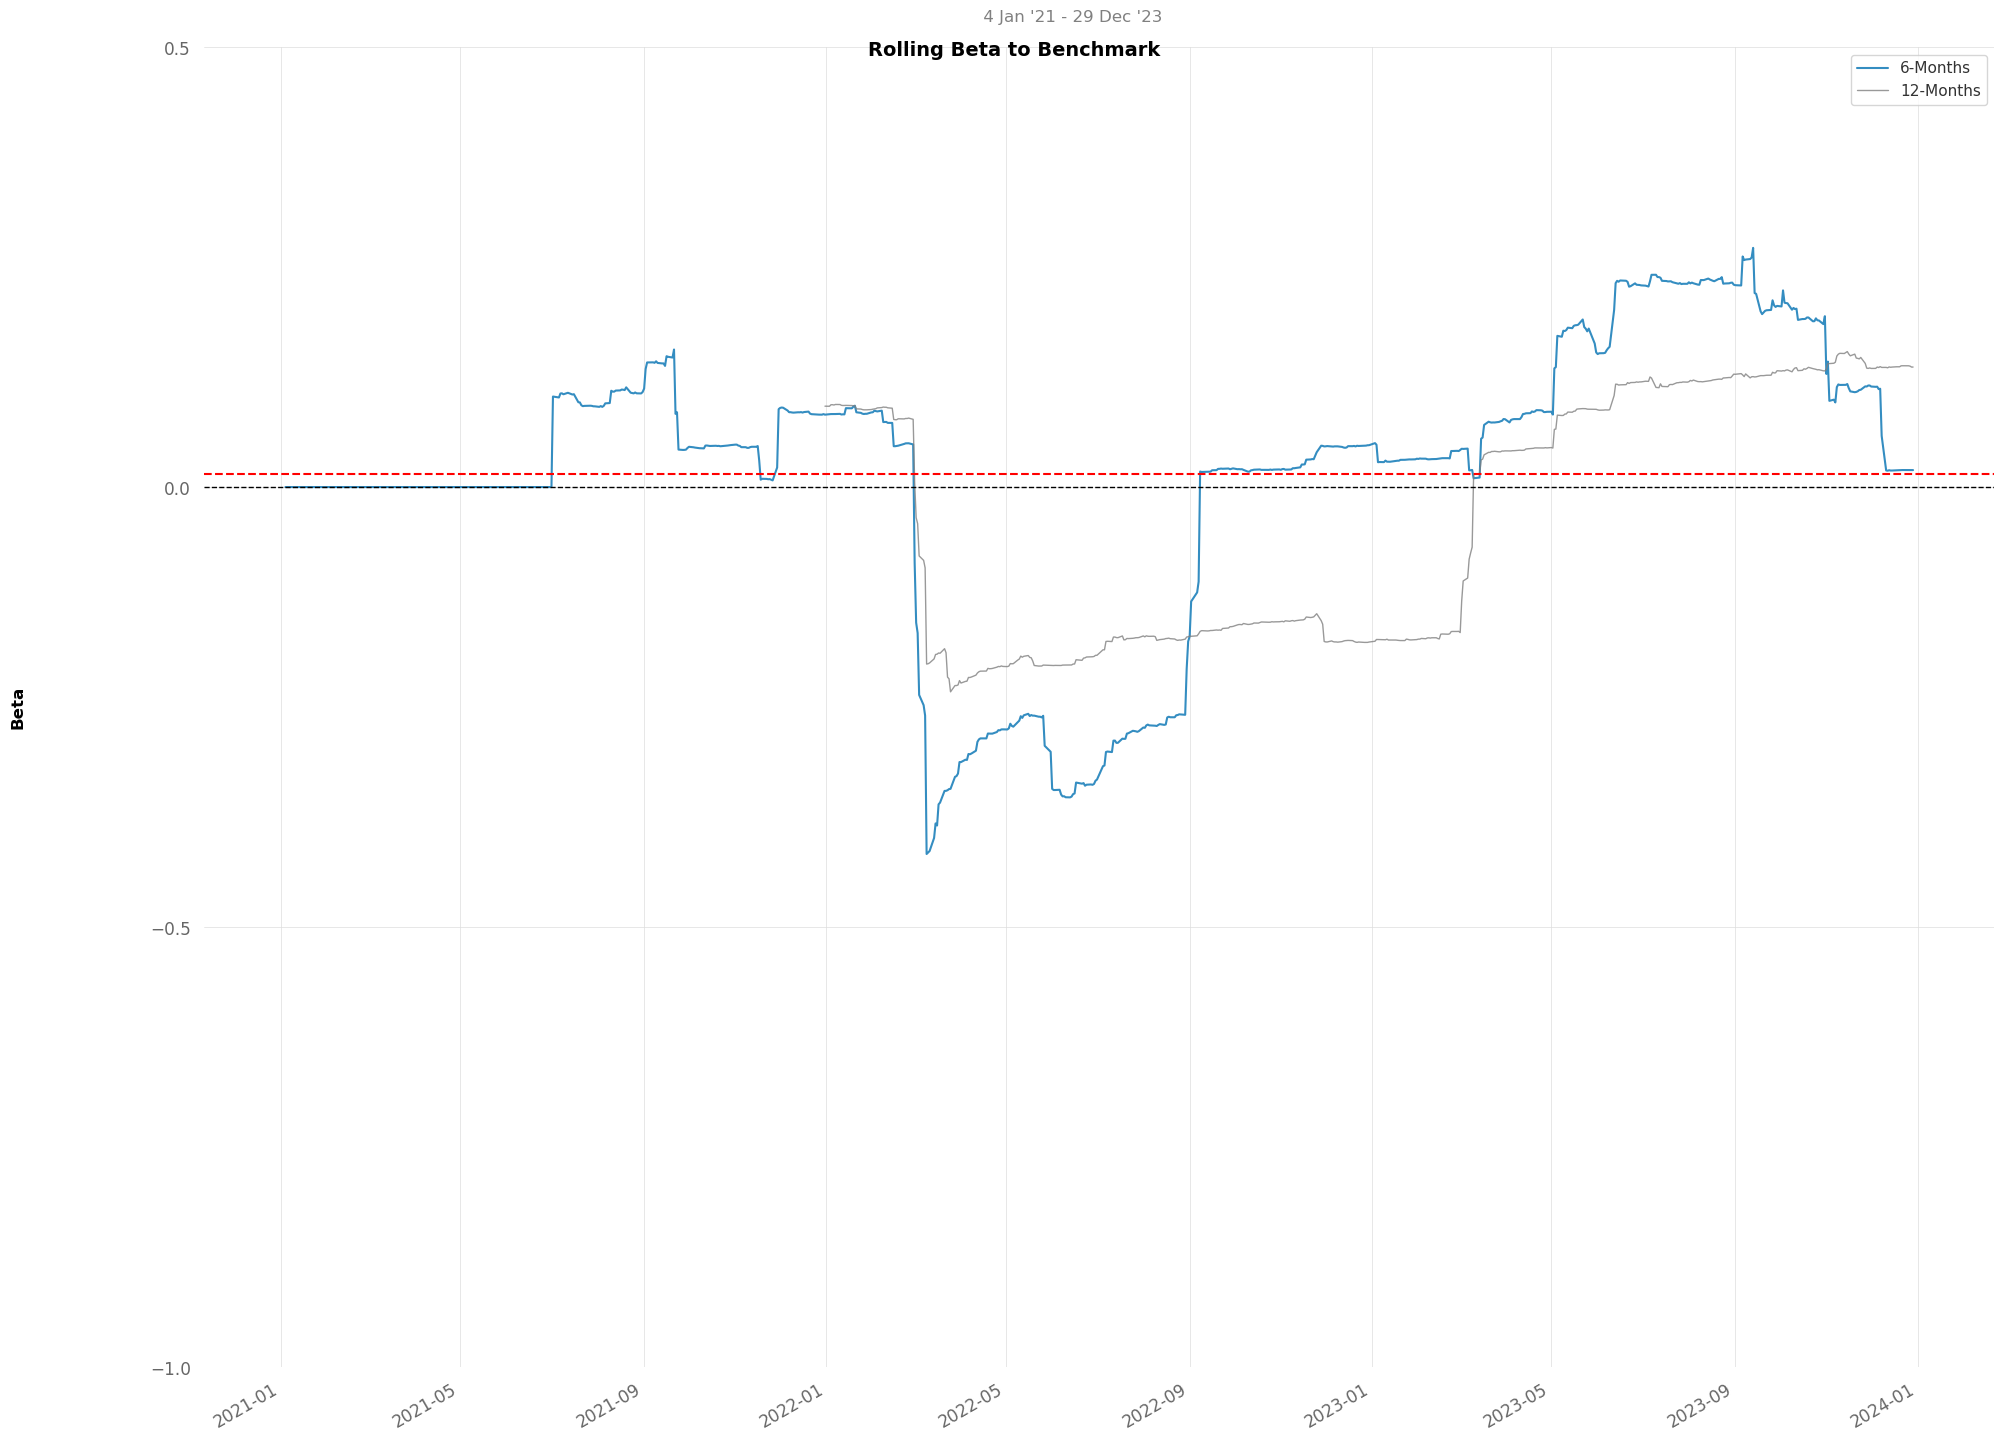

In [44]:
qs.plots.rolling_beta(strategy_returns["strategy_returns"], 
                      benchmark=cl_f, figsize=(20,15))

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


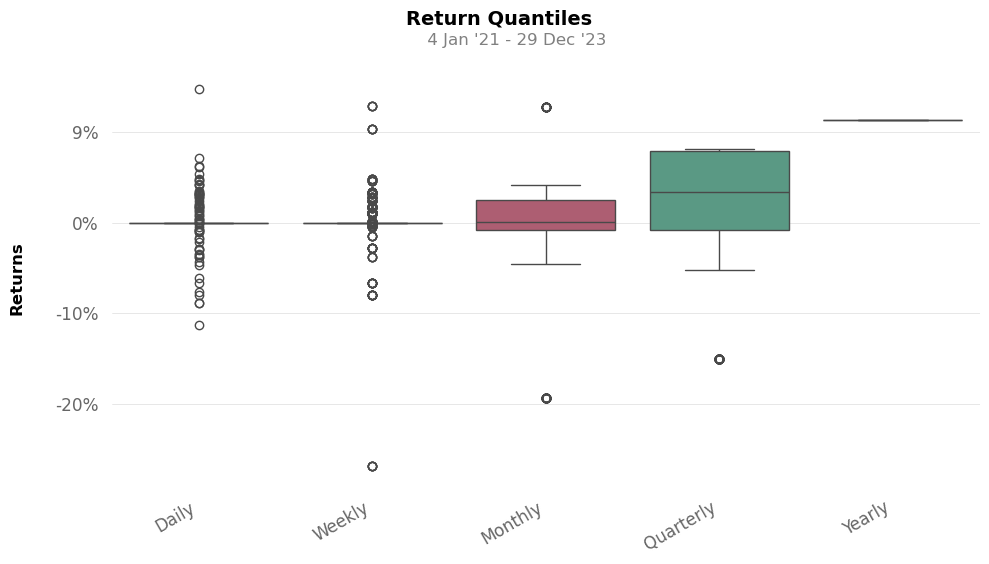

In [42]:
qs.plots.distribution(strategy_returns["strategy_returns"])